In [1]:
import numpy as np
import pandas as pd
import datetime
import statsmodels.tsa.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('../../data/cooked_data/cooked_complete_dataset.csv')

df["date"] = df["date"].apply(lambda x: datetime.datetime.strptime(x, "%d/%m/%Y"))

train = df[df["date"] <= "2021/03/14"]
validation = df[(df["date"] > "2021/03/14") & (df['date'] <= '2021/03/29')]
test = df[(df["date"] > "2021/03/29")]

train.set_index('date', inplace = True)
validation.set_index('date', inplace = True)
test.set_index('date', inplace = True)

In [3]:
def tsplot(y, lags=20, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))    
        y.plot(ax=ts_ax)
        p_value = sm.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        sm.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        sm.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        plt.tight_layout()
    return

In [4]:
for col in train.columns:
    print(col, sm.adfuller(train[col])[1])

Adj_Close_BTC-USD 0.8172453870432123
Open_BTC-USD 0.8885818109779561
High_BTC-USD 0.833705457402641
Low_BTC-USD 0.8945589984143811
Volume_BTC-USD 3.268818504951988e-14
Adj_Close_SPY 0.3009814234683903
Adj_Close_GLD 0.8642970596249564
Adj_Close_CHFUSD=X 0.8838418505067832
Adj_Close_CNYUSD=X 0.10470332640410607
Adj_Close_EURUSD=X 0.49072648211677256
Adj_Close_GBPUSD=X 0.3215774560349039
Adj_Close_JPYUSD=X 0.9983036367997156
coindesk_sentiment 2.7005664144078556e-15
num_of_coindesk_posts 0.23568277999790627
reddit_comments_sentiments 1.004176939970705e-12
top_50_reddit_posts_sentiments 4.717414616205755e-14
blockchain_transactions_per_block 0.028180501713181354
blockchain_hash_rates 0.23633812341621813


In [5]:
# differencing - first order sufficient
for col in train.columns:
    print(col, sm.adfuller(train.diff().dropna()[col])[1])

Adj_Close_BTC-USD 1.6607752524416133e-16
Open_BTC-USD 2.9595350865389216e-16
High_BTC-USD 6.7012852653507226e-15
Low_BTC-USD 9.693805214230111e-15
Volume_BTC-USD 4.354195791267501e-16
Adj_Close_SPY 2.8887351758182727e-16
Adj_Close_GLD 7.226540514907933e-08
Adj_Close_CHFUSD=X 1.916823433139236e-15
Adj_Close_CNYUSD=X 2.791122436235962e-09
Adj_Close_EURUSD=X 1.5319029205965463e-15
Adj_Close_GBPUSD=X 1.8337959350454147e-09
Adj_Close_JPYUSD=X 7.664351479545686e-05
coindesk_sentiment 4.351156918356232e-09
num_of_coindesk_posts 0.00016562268056550877
reddit_comments_sentiments 2.52053351809402e-10
top_50_reddit_posts_sentiments 3.382010406210367e-11
blockchain_transactions_per_block 0.0007240674413093839
blockchain_hash_rates 3.616621655128208e-10


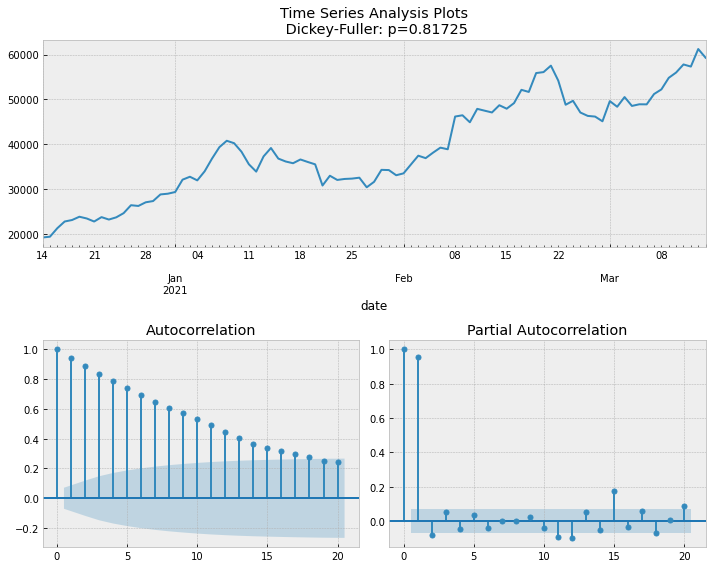

In [6]:
tsplot(train["Adj_Close_BTC-USD"])

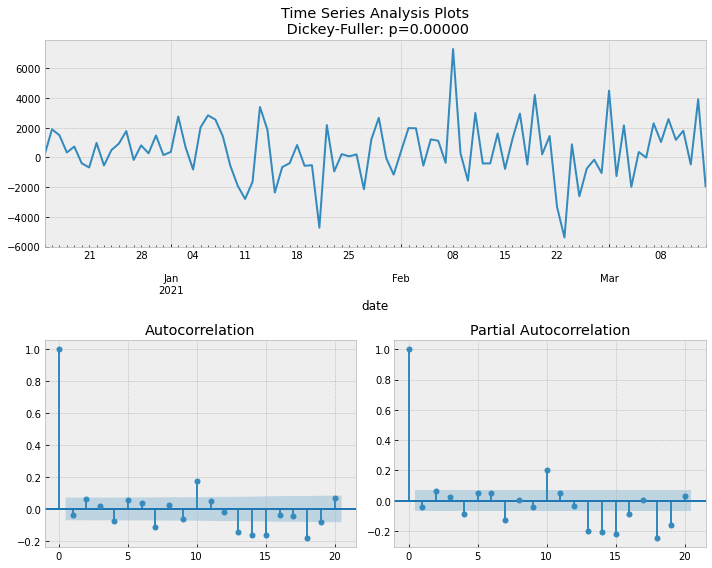

In [7]:
tsplot(train["Adj_Close_BTC-USD"].diff().dropna()) # white noise after differencing

In [8]:
df_differenced = train.diff().dropna()
df_differenced = df_differenced[["Adj_Close_BTC-USD","Adj_Close_SPY", "Adj_Close_GLD","Adj_Close_CHFUSD=X",
                                 "Adj_Close_EURUSD=X","Adj_Close_GBPUSD=X","Adj_Close_JPYUSD=X","blockchain_transactions_per_block",
                                 "blockchain_hash_rates", 'coindesk_sentiment', 'reddit_comments_sentiments', 
                                 'top_50_reddit_posts_sentiments']]

In [9]:
def write_results(results, columns):
    print(results.summary())
    print("================test_whiteness================\n")
    print(results.test_whiteness(nlags=10))
    print("================results.roots()================\n")
    for root in results.roots:
        print(str(root)+",")
    print("\n================is_stable================\n")
    print(str(results.is_stable()))
    print("\n================granger causality================\n")
    for V1 in ["Adj_Close_BTC-USD"]:
        for V2 in columns:
            print("Granger test: "+V2+"-->"+V1+"\n")
            print(results.test_causality(V1, [V2],kind='f').summary())
            print("\n")

## With Sentiment

In [10]:
all_rmse = {}
for lag_order in range(1,11):
    model = VAR(df_differenced)
    results = model.fit(lag_order,trend="c")
    
    # validation set forecasting
    pred_validation = results.forecast(results.y, steps=len(validation))[:,0]
    
    # un-differencing it
    pred_values = [train.loc["2021/03/14",'Adj_Close_BTC-USD']]
    for diff in pred_validation:
        pred_values.append(pred_values[-1] + diff)
    
    # calculate validation set rmse
    rmse = np.sqrt(mean_squared_error(validation["Adj_Close_BTC-USD"], pred_values[1:]))
    all_rmse[lag_order] = rmse

In [11]:
all_rmse # lag3 lowest

{1: 7307.820070247535,
 2: 7614.004572852906,
 3: 7291.011675989055,
 4: 9099.284453485183,
 5: 16530.10078160116,
 6: 9153.552979662349,
 7: 2802115.560021596,
 8: 80912.60599287508,
 9: 119290.82319829728,
 10: 56572.38744713097}

In [12]:
lag_order = 3
results = model.fit(lag_order,trend="c")
write_results(results, df_differenced.columns)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 20, Apr, 2021
Time:                     21:33:56
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                    1.02403
Nobs:                     87.0000    HQIC:                  -6.49316
Log likelihood:          -534.485    FPE:                1.90508e-05
AIC:                     -11.5606    Det(Omega_mle):     2.71072e-07
--------------------------------------------------------------------
Results for equation Adj_Close_BTC-USD
                                           coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------------------
const                                       327.897309       289.129189            1.134           0.257
L1.Adj_Close_BTC-USD                         -0.095546   

Granger causality F-test. H_0: top_50_reddit_posts_sentiments does not Granger-cause Adj_Close_BTC-USD. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.486          2.620   0.217 (3, 600)
----------------------------------------------




In [13]:
# training set forecast
pred_train = []
for timestep in range(df_differenced.shape[0] - lag_order + 1):
    pred_train.append(results.forecast(y=df_differenced.values[0:timestep+lag_order], steps=1)[0][0])

predictions_train = [None, None, df.loc[lag_order-1,'Adj_Close_BTC-USD']]
for diff in pred_train:
    predictions_train.append(predictions_train[-1] + diff)

In [14]:
# validation and test set forecast
pred_test = results.forecast(results.y, steps=len(validation) + len(test))[:,0]

predictions_test = [train.loc["2021/03/14",'Adj_Close_BTC-USD']]
for diff in pred_test:
    predictions_test.append(predictions_test[-1] + diff)

In [15]:
predictions = np.concatenate([predictions_train[3:], predictions_test[1:]])

In [16]:
prediction_all = pd.DataFrame(predictions, index = df.date[3:], columns = ['predicted'])
prediction_all['actual'] = df["Adj_Close_BTC-USD"].values[3:]

In [17]:
prediction_all.to_csv('with_sentiments.csv')

In [18]:
# train rmse
rmse_train = prediction_all.loc[:"2021/03/14"]
rmse = np.sqrt(mean_squared_error(rmse_train.actual, rmse_train.predicted))
print("RMSE : % f" %(rmse))

RMSE :  4737.885655


In [19]:
# test rmse
rmse_test = prediction_all.loc['2021/03/29':]
rmse = np.sqrt(mean_squared_error(rmse_test.actual, rmse_test.predicted))
print("RMSE : % f" %(rmse))

RMSE :  10293.510481


## Without Sentiment

In [20]:
df_differenced = train.diff().dropna()

df_differenced_no_sentiment = df_differenced.drop(['coindesk_sentiment', 'num_of_coindesk_posts', 
                                                   'reddit_comments_sentiments', 'top_50_reddit_posts_sentiments'], 
                                                  axis = 1)
df_differenced_no_sentiment = df_differenced_no_sentiment[["Adj_Close_BTC-USD","Adj_Close_SPY", "Adj_Close_GLD",
                                                           "Adj_Close_CHFUSD=X","Adj_Close_EURUSD=X", "Adj_Close_GBPUSD=X",
                                                           "Adj_Close_JPYUSD=X","blockchain_transactions_per_block",
                                                           "blockchain_hash_rates"]]

In [21]:
all_rmse = {}
for lag_order in range(1,11):
    model = VAR(df_differenced_no_sentiment)
    results = model.fit(lag_order,trend="c")
    
    # validation set forecasting
    pred_validation = results.forecast(results.y, steps=len(validation))[:,0]
    
    # un-differencing it
    pred_values = [train.loc["2021/03/14",'Adj_Close_BTC-USD']]
    for diff in pred_validation:
        pred_values.append(pred_values[-1] + diff)
    
    # calculate validation set rmse
    rmse = np.sqrt(mean_squared_error(validation["Adj_Close_BTC-USD"], pred_values[1:]))
    all_rmse[lag_order] = rmse

In [22]:
all_rmse # lag order 4

{1: 7367.490870768239,
 2: 7114.200881557165,
 3: 7299.818774582153,
 4: 7097.487209493649,
 5: 8146.902045338689,
 6: 13401.321920121542,
 7: 12939.489583149067,
 8: 30689.1726104545,
 9: 40372.87479953727,
 10: 462062.18271723116}

In [23]:
lag_order = 4
results = model.fit(lag_order,trend="c")
write_results(results, df_differenced_no_sentiment.columns)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 20, Apr, 2021
Time:                     21:33:57
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    12.6683
Nobs:                     86.0000    HQIC:                   6.98954
Log likelihood:          -901.347    FPE:                    40.6066
AIC:                      3.16484    Det(Omega_mle):         1.62157
--------------------------------------------------------------------
Results for equation Adj_Close_BTC-USD
                                           coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------------------
const                                       247.403498       323.128348            0.766           0.444
L1.Adj_Close_BTC-USD                         -0.234940   

In [24]:
# training set forecast
pred_train = []
for timestep in range(df_differenced_no_sentiment.shape[0] - lag_order + 1):
    pred_train.append(results.forecast(y=df_differenced_no_sentiment.values[0:timestep+lag_order], steps=1)[0][0])

predictions_train = [df.loc[lag_order-1,'Adj_Close_BTC-USD']]
for diff in pred_train:
    predictions_train.append(predictions_train[-1] + diff)

In [25]:
# test set forecast
pred_test = results.forecast(results.y, steps=len(validation) + len(test))[:,0]

predictions_test = [train.loc["2021/03/14",'Adj_Close_BTC-USD']]
for diff in pred_test:
    predictions_test.append(predictions_test[-1] + diff)

In [26]:
predictions = np.concatenate([predictions_train[1:], predictions_test[1:]])

In [27]:
prediction_all = pd.DataFrame(predictions, index = df.date[4:], columns = ['predicted'])
prediction_all['actual'] = df["Adj_Close_BTC-USD"].values[4:]

In [28]:
prediction_all.to_csv('without_sentiments.csv')

In [29]:
# train rmse
rmse_train = prediction_all.loc[:"2021/03/14"]
rmse = np.sqrt(mean_squared_error(rmse_train.actual, rmse_train.predicted))
print("RMSE : % f" %(rmse))

RMSE :  5116.588492


In [30]:
# test rmse
rmse_test = prediction_all.loc['2021/03/29':]
rmse = np.sqrt(mean_squared_error(rmse_test.actual, rmse_test.predicted))
print("RMSE : % f" %(rmse))

RMSE :  10353.943881
